In [12]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import os
from matplotlib import pyplot as plt
%config InlineBackend.figure_format="retina"
%matplotlib inline
import numpy as np

/var/folders/9n/n4zg7wsd1bj2z86y3xyb_3hh0000gn/T/ipykernel_83289/741028310.py:63: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  marker_width, marker_height = draw.textsize(marker_text, font=font)
/var/folders/9n/n4zg7wsd1bj2z86y3xyb_3hh0000gn/T/ipykernel_83289/741028310.py:63: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  marker_width, marker_height = draw.textsize(marker_text, font=font)
/var/folders/9n/n4zg7wsd1bj2z86y3xyb_3hh0000gn/T/ipykernel_83289/741028310.py:63: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  marker_width, marker_height = draw.textsize(marker_text, font=font)
/var/folders/9n/n4zg7wsd1bj2z86y3xyb_3hh0000gn/T/ipykernel_83289/741028310.py:63: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07

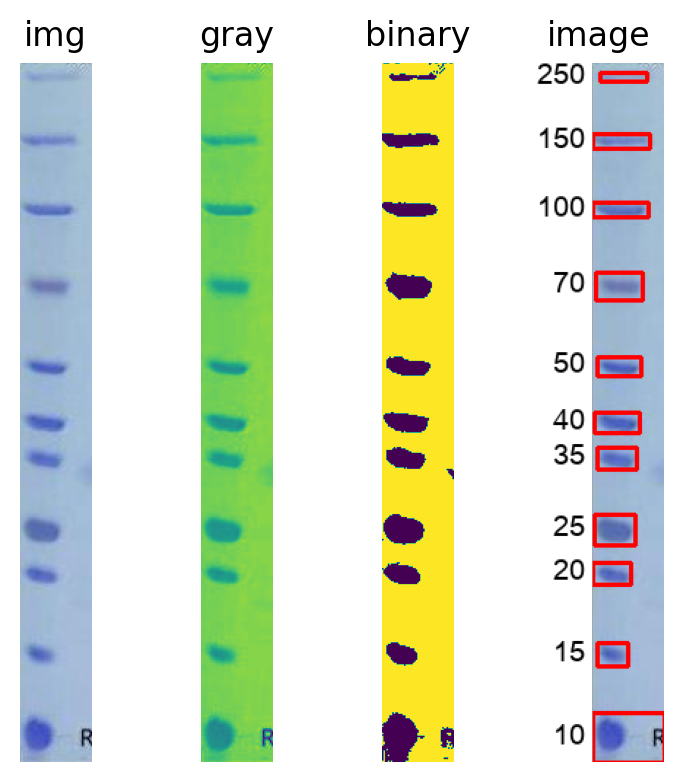

In [14]:
marker_list = [10, 15, 20, 25, 35, 40, 50, 70, 100, 150, 250]

## 原图未处理

# mall_radio默认0.2
# 生成binary时，thresh需调
# img_path,thresh = "/Users/fy/Desktop/picture/0412浓缩后/marker.jpg",178   #很好
# img_path,thresh = "/Users/fy/Desktop/picture/0629浓缩后/marker.jpg",185   #small_radio=0.1只剩第一条未识别
# img_path,thresh = "/Users/fy/Desktop/picture/20230505_E/marker.jpg",170  #marker有问题
# img_path,thresh = "/Users/fy/Desktop/picture/20230523_E/marker.jpg",165  #第一条未识别 
# img_path,thresh = "/Users/fy/Desktop/picture/20230526_E/marker.jpg",200  #前两条未识别  
# img_path,thresh = "/Users/fy/Desktop/picture/20230531_E/marker.jpg",183  #很好
# img_path,thresh = "/Users/fy/Desktop/picture/20230605_E/marker.jpg",190  #很好
# img_path,thresh = "/Users/fy/Desktop/picture/20230607_E/marker.jpg",135  #很好
# img_path,thresh = "/Users/fy/Desktop/picture/20230628_E/marker.jpg",199  #第一条未识别

imgBGR = cv2.imread(img_path)
img = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
thresh, binary = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(~binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #binary反转是为了不把最外层的轮廓框出来

contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[2], reverse=True)
max_width = cv2.boundingRect(contours[0])[2]
contours = [c for c in contours if cv2.boundingRect(c)[2] > max_width * 0.2]


rectangles = [cv2.boundingRect(cnt) for cnt in contours]
rectangles.sort(key=lambda x: x[1])  # 按照 y 坐标进行排序
merged_rectangles = []
current_rect = rectangles[0]

for rect in rectangles[1:]:
    if rect[1] - current_rect[1] <= current_rect[3]:  # 判断是否有重叠
        current_rect = (
            min(current_rect[0], rect[0]),
            min(current_rect[1], rect[1]),
            max(current_rect[0] + current_rect[2], rect[0] + rect[2]) - min(current_rect[0], rect[0]),
            max(current_rect[3], rect[3])
        )
    else:
        merged_rectangles.append(current_rect)
        current_rect = rect
merged_rectangles.append(current_rect)

img_contours = img.copy()
for rect in merged_rectangles:
    x, y, w, h = rect
    cv2.rectangle(img_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)

img_contours = Image.fromarray(img_contours)

image = Image.new('RGBA', (img_contours.width + 40, img_contours.height))
image.paste(img_contours, (40, 0))


merged_rectangles = sorted(merged_rectangles, key=lambda c: c[1], reverse=True)
for i, rect in enumerate(merged_rectangles):
    x, y, w, h = rect
    marker_text = str(marker_list[i])
    font = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf", 20)
    draw = ImageDraw.Draw(image)
    marker_width, marker_height = draw.textsize(marker_text, font=font)
    # print(i, y, h, marker_width, marker_height)
    position = (35-marker_width, y-6+0.5*h-0.5*marker_height)  
    draw.text(position, marker_text, font=font, fill=(0, 0, 0, 255))  # 黑色文字

image.save(f'{img_path[:-4]}.png', format='PNG')


plt.figure(figsize=(4,4))
plt.subplot(141),plt.imshow(img),plt.title("img"),plt.axis('off')
plt.subplot(142),plt.imshow(gray),plt.title("gray"),plt.axis('off')
plt.subplot(143),plt.imshow(binary),plt.title("binary"),plt.axis('off')
# plt.subplot(144),plt.imshow(img_contours),plt.title('img_contours'),plt.axis('off')
plt.subplot(144),plt.imshow(image),plt.title('image'),plt.axis('off')

plt.tight_layout()
plt.show()

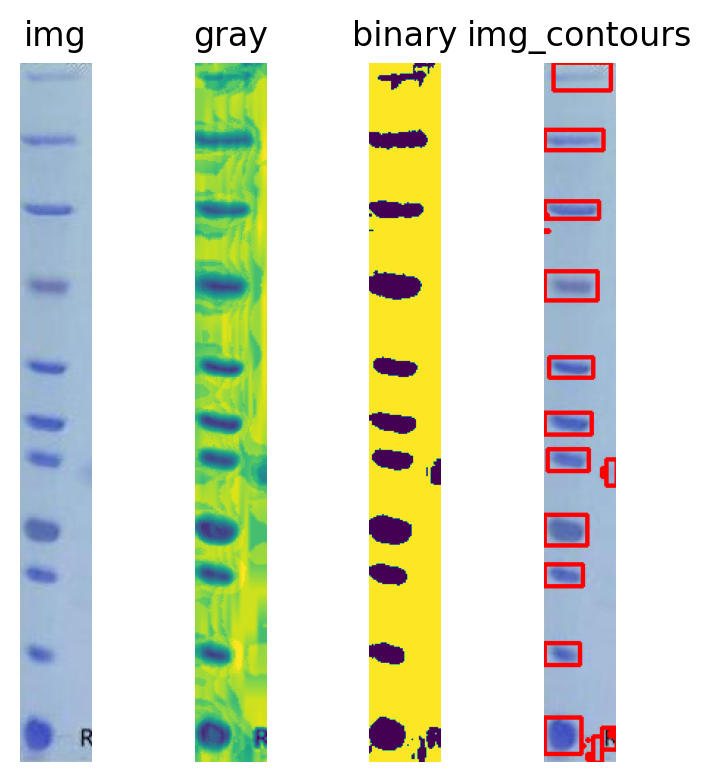

In [42]:
def preprocess_image(img):
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 5)  # 使用颜色图像去噪声
    img = cv2.GaussianBlur(img, (3, 3), 0)  # 高斯模糊
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转为灰度图像
    # return gray_image
    clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(20, 20)) # 增加局部对比度（CLAHE）
    enhanced_image = clahe.apply(gray_image)
    return enhanced_image

    
img_path = "/Users/fy/Desktop/picture/0412浓缩后/marker.jpg"
# img_path = "/Users/fy/Desktop/picture/0629浓缩后/marker.jpg"
# img_path = "/Users/fy/Desktop/picture/20230505_E/marker.jpg"
# img_path = "/Users/fy/Desktop/picture/20230523_E/marker.jpg"



imgBGR = cv2.imread(img_path)
img = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
gray = preprocess_image(img)
thresh, binary = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(~binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_contours = img.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(figsize=(4,4))
plt.subplot(141),plt.imshow(img),plt.title("img"),plt.axis('off')
plt.subplot(142),plt.imshow(gray),plt.title("gray"),plt.axis('off')
plt.subplot(143),plt.imshow(binary),plt.title("binary"),plt.axis('off')
plt.subplot(144),plt.imshow(img_contours),plt.title('img_contours'),plt.axis('off')
plt.tight_layout()
plt.show()